# Sequence Models & How to use them

**학습목표**
1. RNN, LSTM, GRU의 구조를 이해한다.
2. 위 모델을 사용하기 위한 데이터 구조를 이해한다.
3. 위 모든 내용을 코딩할 수 있다.

-----------------
* Thanks to : 한기영 대표님 @ Data Insight

## 1.환경 및 데이터 준비

### Import Packages

In [38]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error



### Data Loading

In [39]:
url = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Stock_Edwards_Lifesciences_corporation.csv'

# 판다스로 데이터를 불러오시오.
data = pd.read_csv(url)
data.tail(10)

,Date,Open,High,Low,Close,Adj_Close,Volume
4382,2017/8/25,112.949997,113.400002,111.720001,111.760002,111.760002,1206400
4383,2017/8/28,112.559998,113.449997,112.470001,113.110001,113.110001,1050200
4384,2017/8/29,112.320000,113.250000,111.739998,111.830002,111.830002,1366000
4385,2017/8/30,112.019997,112.989998,111.529999,112.690002,112.690002,929200
4386,2017/8/31,112.820000,113.790001,112.440002,113.660004,113.660004,1091400
4387,2017/9/1,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,2017/9/5,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,2017/9/6,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,2017/9/7,112.459999,112.900002,112.000000,112.339996,112.339996,1251600
4391,2017/9/8,112.300003,114.790001,112.010002,113.190002,113.190002,1611700


### !!! 2. 데이터 이해
### 탐색하기

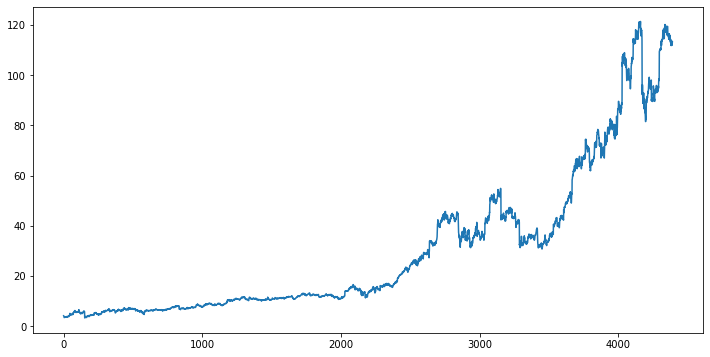

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(data.Close)
plt.show()

In [41]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

##3.데이터 준비

### Date 컬럼을 제거하시오.

In [42]:
data.drop('Date', axis = 1, inplace=True)

In [43]:
data.tail()

,Open,High,Low,Close,Adj_Close,Volume
4387,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,112.459999,112.900002,112.000000,112.339996,112.339996,1251600
4391,112.300003,114.790001,112.010002,113.190002,113.190002,1611700


## 4.Sequence 데이터 구조로 만들기

**조건**
* 내일의 Close를 예측할 것이다. 이를 Y로 둘 것.
* timestep은 4주를 본다. (주식은 5일이 1주일)
* 맞추어 전처리

**데이터 분할 규칙**
* 가장 최근 1주일을 테스트 데이터로 둔다.
* 테스트 데이터를 제외하고, 가장 최근 2주를 벨리데이션 데이터로 둔다.
********************* 2주 중 5일이 1주일이라 했으니 5*2 = 10 ****************

In [44]:
# 판다스 데이터 프레임을 넘파이로 옮김.
data = data.values # df의 값을 np array로 넘긴다.

In [45]:
data.shape

(4392, 6)

In [48]:
# close 컬럼의 위치를 주의해 주세요.
# 너무 어렵다면, 앞전 실습의 코드를 가져다가 '수정'해보는 전략으로 진행하는 것도 좋습니다.

# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
timestep = 20 # 한 번에 21주씩 고려하자.

# x의 데이터 구조를 3차원으로 만들어 줘야 함
x = np.array([data[i : i + timestep] for i in range( len(data) - timestep) ])
y = np.array([data[i + timestep, -1] for i in range( len(data) - timestep) ])

x_train, x_val, x_test = x[:-15], x[-15:-5], x[-5:]
y_train, y_val, y_test = y[:-15], y[-15:-5], y[-5:]

## 모양 확인 필수
print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
print('-------------------------------')
print('[ # , timestep, feature수 ] <-- 데이터의 구조 : ')


(4372, 20, 6) (4372,)
-------------------------------
(4357, 20, 6) (4357,)
(10, 20, 6) (10,)
(5, 20, 6) (5,)
-------------------------------
[ # , timestep, feature수 ] <-- 데이터의 구조 : 


데이터의 구조 : [n, timestep, feature수]

# Q.1. 단순 RNN복습

1. 적절한 인풋 레이어를 구성할 것
2. 첫번째 히든레이어 : SimpleRNN
    * 히든스테이트 노드 16개, return_sequences=True
3. 두번째 히든레이어 : SimpleRNN
    * 히든스테이트 노드 32개, return_sequences=True
4. 플래튼
5. 회귀를 위한 적절한 아웃풋 레이어

![image.png](attachment:image.png)

In [49]:
x_train.shape, y_train.shape

((4357, 20, 6), (4357,))

In [51]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten

In [57]:
####################
## Your Code Here ##
####################
# 1. 세션클리어
keras.backend.clear_session()

# 2. Sequential 모델 선언하기
model = keras.models.Sequential(name='my_first_rnn')

# 3. 모델 구조 짜기
# 적절한 인풋 레이어를 구성할 것
# model.add(Input(shape = ( 한꺼번에 관찰할 시점 수, 시점별 feature 개수 )))
model.add(Input(shape = ( 21, 1), name = 'input_layer'))
# 첫번째 히든레이어 : SimpleRNN 히든스테이트 노드 16개, return_sequences = True
model.add(SimpleRNN( 16, activation = 'tanh', return_sequences = True, name = 'hidden1_rnn' ))
# 두번째 히든레이어 : SimpleRNN 히든스테이트 노드  32개, return_sequences = True
model.add(SimpleRNN( 32, activation = 'tanh', return_sequences = True, name = 'hidden2_rnn' ))
# 플래튼
model.add(Flatten(name = 'hidden3_flatten'))
# 회귀를 위한 적절한 아웃풋 레이어
model.add(Dense(1))
# 4. 모델 컴파일
model.compile(loss = 'mse', optimizer = 'adam') # 'mae'는 'mse' 대비 급격한 학습을 막는데 종종 사용이 된다.

# (옵션). 모델 요약
model.summary()

Model: "my_first_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_rnn (SimpleRNN)     (None, 21, 16)            288       
                                                                 
 hidden2_rnn (SimpleRNN)     (None, 21, 32)            1568      
                                                                 
 hidden3_flatten (Flatten)   (None, 672)               0         
                                                                 
 dense (Dense)               (None, 1)                 673       
                                                                 
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
_________________________________________________________________


In [60]:
## 학습도 시킬 것
hist = model.fit(x_train, y_train, epochs = 100, validation_data = (x_val, y_val), verbose = 1)


Epoch 1/100


ValueError: ignored

In [ ]:
# 학습 곡선을 그린다
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

In [55]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
from sklearn.metrics import mean_squared_error as MSE

y_pred = model.predict(x_test)
MSE(y_test, y_pred) ** 0.5


ValueError: ignored

In [56]:
model.summary()

Model: "my_first_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_rnn (SimpleRNN)     (None, 21, 16)            288       
                                                                 
 hidden2_rnn (SimpleRNN)     (None, 21, 32)            1568      
                                                                 
 hidden3_flatten (Flatten)   (None, 672)               0         
                                                                 
 dense (Dense)               (None, 1)                 673       
                                                                 
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model, show_shapes = True)

# Q.2. LSTM, GRU 복습

1. 적절한 인풋 레이어를 구성할 것
2. 첫번째 히든레이어 : LSTM
    * 히든스테이트 노드 16개, return_sequences=True
3. 두번째 히든레이어 : GRU
    * 히든스테이트 노드 32개, return_sequences=True
4. 플래튼
5. Fully Connected Layer, 노드 128개, swish
5. 회귀를 위한 적절한 아웃풋 레이어

In [ ]:
####################
## Your Code Here ##
####################



In [ ]:
## 학습도 시킬 것



In [ ]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.

